In [1]:
import requests
 
ensembl_server = 'http://rest.ensembl.org'

def do_request(server, service, *args, **kwargs):
    params = ''
    for a in args:
        if a is not None:
            params += '/' + a
    req = requests.get('%s/%s%s' % (server, service, params),
                       params=kwargs,
                       headers={'Content-Type': 'application/json'})
 
    if not req.ok:
        req.raise_for_status()
    return req.json()

Let’s start by retrieving all GO terms associated with the LCT gene (you learned how to retrieve
the Ensembl ID in the previous recipe). 

In [2]:
lct_id = 'ENSG00000115850'

refs = do_request(ensembl_server, 'xrefs/id', lct_id, external_db='GO', all_levels='1')
print(len(refs))
print(refs[0].keys())
for ref in refs:
    go_id = ref['primary_id']
    details = do_request(ensembl_server, 'ontology/id', go_id)
    print('%s %s %s' % (go_id,  details['namespace'], ref['description']))
    print('%s\n' % details['definition'])

36
dict_keys(['linkage_types', 'info_text', 'db_display_name', 'synonyms', 'primary_id', 'dbname', 'info_type', 'display_id', 'version', 'description'])
GO:0000016 molecular_function lactase activity
Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose.

GO:0000016 molecular_function lactase activity
Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose.

GO:0000016 molecular_function lactase activity
Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose.

GO:0003824 molecular_function catalytic activity
Catalysis of a biochemical reaction at physiological temperatures. In biologically catalyzed reactions, the reactants are known as substrates, and the catalysts are naturally occurring macromolecular substances known as enzymes. Enzymes possess specific binding sites for substrates, and are usually composed wholly or largely of protein, but RNA that has catalytic activity (ribozyme) is often also regarded as enzymatic.

GO:0004336 molecular_funct

Let’s concentrate on the lactase activity molecular function and retrieve more detailed
information about it (the following `go_id `comes from the previous step):

We print the lactase activity record (which is currently a node of the GO tree molecular function) and retrieve a list of potential parents. There is a single parent for this record. We retrieve it and print the number of children.

In [3]:
go_id = 'GO:0000016'
my_data = do_request(ensembl_server, 'ontology/id', go_id)
for k, v in my_data.items():
    if k == 'parents':
        for parent in v:
            print(parent)
            parent_id = parent['accession']
    else:
        print('%s: %s' % (k, str(v)))
print()
parent_data = do_request(ensembl_server, 'ontology/id', parent_id)
print(parent_id, len(parent_data['children']))

namespace: molecular_function
ontology: GO
subsets: []
{'accession': 'GO:0004553', 'namespace': 'molecular_function', 'ontology': 'GO', 'subsets': [], 'synonyms': [], 'name': 'hydrolase activity, hydrolyzing O-glycosyl compounds', 'definition': 'Catalysis of the hydrolysis of any O-glycosyl bond.'}
synonyms: []
children: []
accession: GO:0000016
definition: Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose.
name: lactase activity

GO:0004553 127


Let’s retrieve all the general terms for the lactase activity molecular function (again, the parent and all other ancestors):

We retrieve the ancestor list by following the `is_a` relationship (refer to the GO sites in the See also section for more details on the types of possible relationships).

In [4]:
refs = do_request(ensembl_server, 'ontology/ancestors/chart', go_id)
for go, entry in refs.items():
    print(go)
    term = entry['term']
    print('%s %s' % (term['name'], term['definition']))
    is_a = entry.get('is_a', [])
    print('\t is a: %s\n' % ', '.join([x['accession'] for x in is_a]))

GO:0004553
hydrolase activity, hydrolyzing O-glycosyl compounds Catalysis of the hydrolysis of any O-glycosyl bond.
	 is a: GO:0016798

GO:0016798
hydrolase activity, acting on glycosyl bonds Catalysis of the hydrolysis of any glycosyl bond.
	 is a: GO:0016787

GO:0000016
lactase activity Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose.
	 is a: GO:0004553

GO:0003674
molecular_function A molecular process that can be carried out by the action of a single macromolecular machine, usually via direct physical interactions with other molecular entities. Function in this sense denotes an action, or activity, that a gene product (or a complex) performs. These actions are described from two distinct but related perspectives: (1) biochemical activity, and (2) role as a component in a larger system/process.
	 is a: 

GO:0016787
hydrolase activity Catalysis of the hydrolysis of various bonds, e.g. C-O, C-N, C-C, phosphoric anhydride bonds, etc. Hydrolase is the systematic name 

Let’s define a function that will create a dictionary with the ancestor relationship for a term, along with some summary information for each term returned in a pair:

In [16]:
def get_upper(go_id):
    parents = {}
    node_data = {}
    refs = do_request(ensembl_server, 'ontology/ancestors/chart', go_id)
    for ref, entry in refs.items():
        my_data = do_request(ensembl_server, 'ontology/id', ref)
        node_data[ref] = {'name': entry['term']['name'], 'children': my_data['children']}
        try:
            parents[ref] = [x['accession'] for x in entry['is_a']]
        except KeyError:
            pass  # Top of hierarchy
    return parents, node_data

Finally, we will print a tree of relationships for the lactase activity term. For this, we
will use the `pygraphivz` library:

In [10]:
! apt-get install python3-dev graphviz libgraphviz-dev pkg-config

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
graphviz is already the newest version (2.40.1-2).
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 27 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/ma

In [11]:
pip install pygraphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pygraphviz-1.7.zip (118 kB)
  Created wheel for pygraphviz: filename=pygraphviz-1.7-cp37-cp37m-linux_x86_64.whl size=165741 sha256=abc14d2bb49adfe3cdb663cbe0167aec8b8ecbd3a2cab355d737a2bcd6cd9419
  Stored in directory: /root/.cache/pip/wheels/8c/bc/0c/ac35392b72556e75107ff610cb31b313e8471918a6d280e34c
Successfully built pygraphviz


strict digraph "" {
	"molecular_function
(GO:0003674)" -> "...28...";
	"molecular_function
(GO:0003674)" -> "catalytic activity
(GO:0003824)";
	"catalytic activity
(GO:0003824)" -> "hydrolase activity
(GO:0016787)";
	"catalytic activity
(GO:0003824)" -> "...21...";
	"hydrolase activity
hydrolyzing O-glycosyl compounds
(GO:0004553)" -> "...126...";
	"hydrolase activity
hydrolyzing O-glycosyl compounds
(GO:0004553)" -> "lactase activity
(GO:0000016)";
	"hydrolase activity
(GO:0016787)" -> "...24...";
	"hydrolase activity
(GO:0016787)" -> "hydrolase activity
acting on glycosyl bonds
(GO:0016798)";
	"hydrolase activity
acting on glycosyl bonds
(GO:0016798)" -> "hydrolase activity
hydrolyzing O-glycosyl compounds
(GO:0004553)";
	"hydrolase activity
acting on glycosyl bonds
(GO:0016798)" -> "...2...";
}



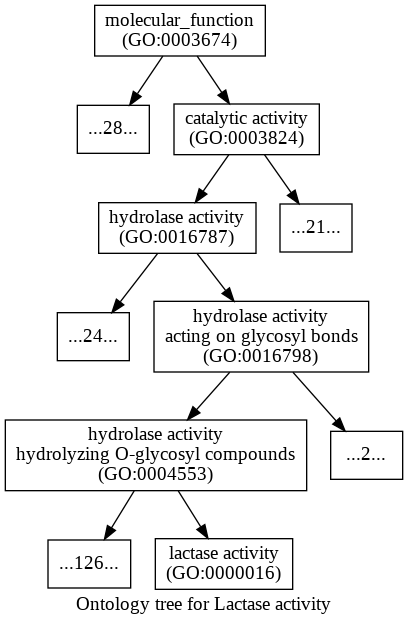

In [17]:
import pygraphviz as pgv
from IPython.core.display import Image


parents, node_data = get_upper(go_id)

g = pgv.AGraph(directed=True)
for ofs, ofs_parents in parents.items():
    ofs_text = '%s\n(%s)' % (node_data[ofs]['name'].replace(', ', '\n'), ofs)
    for parent in ofs_parents:
        parent_text = '%s\n(%s)' % (node_data[parent]['name'].replace(', ', '\n'), parent)
        children = node_data[parent]['children']
        if len(children) < 3:
            for child in children:
                if child['accession'] in node_data:
                    continue
                g.add_edge(parent_text, child['accession'])
        else:
            g.add_edge(parent_text, '...%d...' % (len(children) - 1))
        g.add_edge(parent_text, ofs_text)
print(g)
g.graph_attr['label']='Ontology tree for Lactase activity'
g.node_attr['shape']='rectangle'
g.layout(prog='dot')
g.draw('graph.png')
Image("graph.png")